In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
#Create Original + Noise Images
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

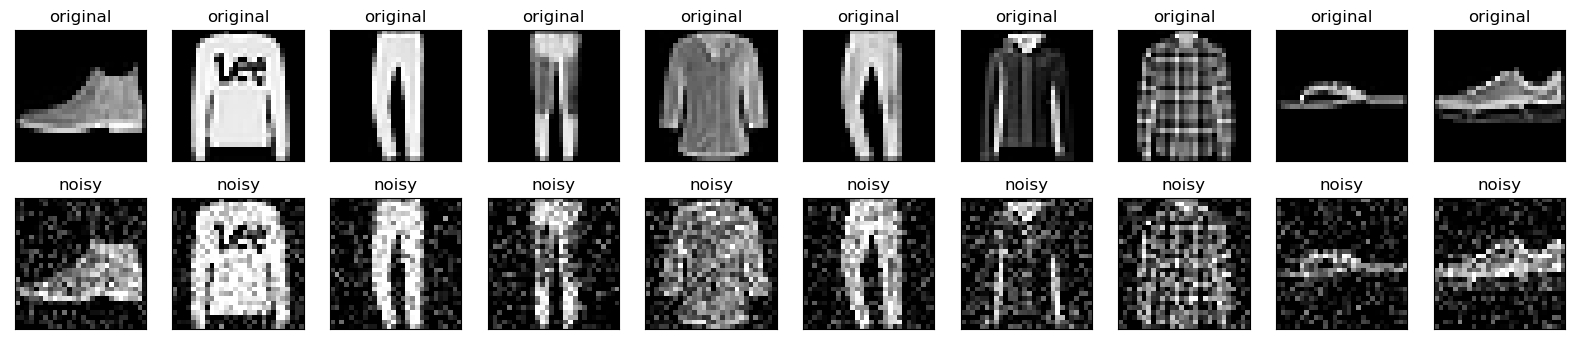

In [4]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    #display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display noisy image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(x_test_noisy[i])
    plt.title('noisy')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [5]:
#build denosing autoencoder using CNN
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28,28,1)),
            layers.Conv2D(16,(3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8,(3,3),activation='relu',padding='same',strides=2)
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same')
        ])
        
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
autoencoder = Denoise()

In [6]:
#Compile the model
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [8]:
#automatically stop training the model based on minimum loss
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)

#train the model
history = autoencoder.fit(x_train_noisy, x_train,
                         epochs=20,
                         shuffle=True,
                         callbacks=[early_stop],
                         validation_data=(x_test_noisy, x_test))

Epoch 1/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0168 - val_loss: 0.0102
Epoch 2/20
1875/1875 [==============================] - 29s 16ms/step - loss: 0.0094 - val_loss: 0.0088
Epoch 3/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0084 - val_loss: 0.0081
Epoch 4/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 7/20
1875/1875 [==============================] - 31s 17ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/20
1875/1875 [==============================] - 31s 16ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/20
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/20
1875/1875 [==============================] - 30s 16m

In [9]:
#autoencoder Summary
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1320 (5.16 KB)
Trainable params: 1320 (5.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1897 (7.41 KB)
Trainable params: 1897 (7.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


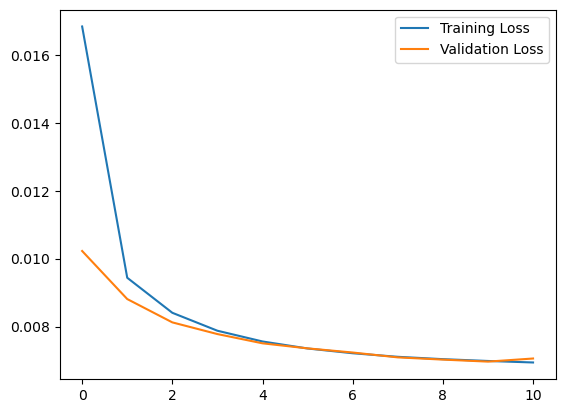

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

In [12]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

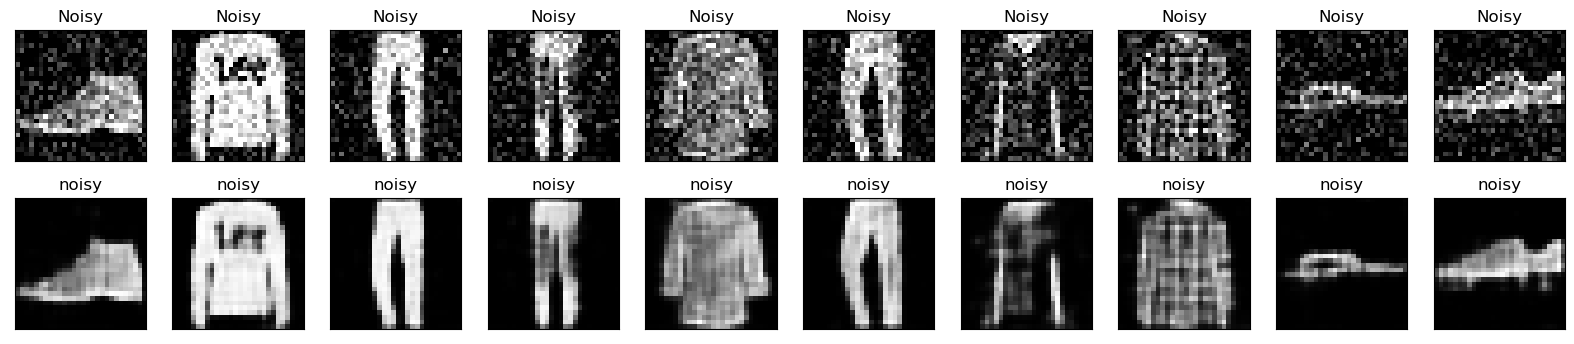

In [13]:
n=10
plt.figure(figsize=(20, 4))
for i in range(n):
    #display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i])
    plt.title("Noisy")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #display noisy image
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title('noisy')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()